# Netzwerk aus Dokumenten aufgrund ihrer Ähnlichkeit

- Wir probieren nun was ganz anderes. Nämlich ein Netzwerk aus Dokumenten zu bauen aufgrund ihrer Ähnlichkeit zueinander. 
- Die Idee dahinter ist Dokumente visuell zu clustern und so zu erkennnen welche ähnlichen Dokumente zusammengehören. 
- Wir probieren das mal anhand der Berichterstattung auf der Fronpage von swissinfo. 

# Artikel von der Front Page scrapen
- Zuerst scrapen wir die Artikel von der Frontpage

In [8]:
import requests
from bs4 import BeautifulSoup
import nltk

In [3]:
# Get 100 Frontpage Items
frontpage_url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/overview"
r = requests.get(frontpage_url).json()
items = []
urls = []
for item in r["page"]["item"][0]["content"]:
    try:
        tmp = requests.get("https://www.swissinfo.ch/webservice/swi-eng-2.0/detail%s" % item["url"])
        text = BeautifulSoup(tmp.json()["htmldetail"], "lxml").get_text()
        items.append(text)
        urls.append(item["canonical"])
        print("Done: %s" % item["url"])
    except:
        pass

Done: /webservice/swi-eng-2.0/detail/42579872/44616080
Done: /webservice/swi-eng-2.0/detail/42579872/44617654
Done: /webservice/swi-eng-2.0/detail/42579872/44617816
Done: /webservice/swi-eng-2.0/detail/42579872/44615866
Done: /webservice/swi-eng-2.0/detail/42579872/44615656
Done: /webservice/swi-eng-2.0/detail/42579872/44613728
Done: /webservice/swi-eng-2.0/detail/42579872/44616450
Done: /webservice/swi-eng-2.0/detail/42579872/44612456
Done: /webservice/swi-eng-2.0/detail/42579872/44613232
Done: /webservice/swi-eng-2.0/detail/42579872/44574850
Done: /webservice/swi-eng-2.0/detail/42579872/44609546
Done: /webservice/swi-eng-2.0/detail/42579872/44609428
Done: /webservice/swi-eng-2.0/video/42579874/44593580
Done: /webservice/swi-eng-2.0/detail/42579872/44608456
Done: /webservice/swi-eng-2.0/detail/42579872/44572400
Done: /webservice/swi-eng-2.0/gallery/42579876/44607960
Done: /webservice/swi-eng-2.0/detail/42579872/44607262
Done: /webservice/swi-eng-2.0/video/42579874/44607858
Done: /webs

In [4]:
items[1][0:300]

u'    Switzerland sets legal foundations for blockchain industry - SWI swissinfo.ch             Blockchain and crypto tokens have the potential to bring efficiencies and cost savings to a range of industries.(Dado Runic / Reuters)       The Swiss government has announced a wide-ranging blockchain stra'

In [5]:
urls[1]

u'https://www.swissinfo.ch/eng/business/dlt-report_switzerland-sets-legal-foundations-for-blockchain-industry/44617654'

# Dokumentenähnlichkeit bestimmen
- Work tokenization
- Stemming
- Stopword removal
- (Clustering with k-means)

In [9]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns

def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def cluster_items(items, nb_of_clusters=5,mds=False):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(items)
        
        # Show matrix
        pairwise_similarity = tfidf_matrix * tfidf_matrix.T
        ax = sns.heatmap(pairwise_similarity.A)
        ax.plot()
        
        # Clustering
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        if mds:
            return [pairwise_similarity,dict(clusters)]
        else:
            return dict(clusters)


#items = ["Nature is beautiful","I like green apples", "We should protect the trees","Fruit trees provide fruits","Green apples are tasty"]

#nclusters= 3
#parwise_similarity, clusters = cluster_items(items, nclusters,True)

# Baby example: Wie funktioniert das nochmal?

Wie sieht das Resultat aus für:
- 2 Sätze mit nature
- 2 Sätze mit apple
- 1 Satz mit apple and nature
- 1 Satz mit computers

In [1]:
nclusters = 3
baby_items = ["Nature is beautiful",
              "We should protect nature",
              "I like green apples", 
              "Green apples are tasty",
              "Apples and nature are fun.",
              "Technical sentence with computers."]
result,clusters = cluster_items(baby_items,nclusters,True)

NameError: name 'cluster_items' is not defined

In [11]:
clusters

{0: [2, 3], 1: [4, 5], 2: [0, 1]}

In [12]:
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,item in enumerate(clusters[cluster]):
                print "\titem ",i,": ",baby_items[item]

cluster  0 :
	item  0 :  I like green apples
	item  1 :  Green apples are tasty
cluster  1 :
	item  0 :  Apples and nature are fun.
	item  1 :  Technical sentence with computers.
cluster  2 :
	item  0 :  Nature is beautiful
	item  1 :  We should protect nature


## Jetzt die Ähnlichkeit der Artikel auf der Frontpage bestimmen

cluster  0 :
	url  politics :  un-migration-pact_where-swiss-development-aid-meets-migration
	url  business :  dlt-report_switzerland-sets-legal-foundations-for-blockchain-industry
	url  society :  new-drugs_do-we-need-clinics-for-internet-and-sex-addicts-
	url  eng :  international-law_tale-of-swiss-based-syrian-torture-survivor-highlights-dublin-flaws
	url  business :  underrepresented-women_men-appointed-to-boards-because-it-s--easier-
	url  business :  inside-geneva_what-now-for-syria-
	url  society :  ten-a-side_ok-google--what-the-swiss-search-for
	url  society :  corruption_venezuelan-ex-minister-hoarded-money-in-switzerland
	url  politics :  opinion_climate-change-is-a-reality-we-need-to-confront--so-is-denialism
cluster  1 :
	url  politics :  un-migration-pact_where-swiss-development-aid-meets-migration
	url  business :  dlt-report_switzerland-sets-legal-foundations-for-blockchain-industry
	url  society :  new-drugs_do-we-need-clinics-for-internet-and-sex-addicts-
	url  eng : 

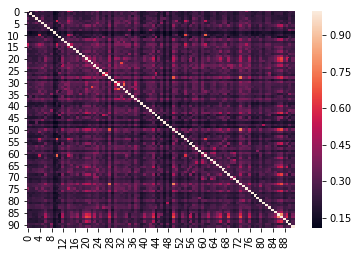

In [13]:
result,clusters = cluster_items(items,nclusters,True)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,item in enumerate(clusters[cluster]):
                print "\turl ",urls[i].split("/")[-3],": ",urls[i].split("/")[-2]

# Als Netzwerk exportieren

In [36]:
import networkx as nx
G  = nx.Graph(name="Texts")

for url in urls:
    url_clean = url.split("/")[-2]
    G.add_node(url, size=1, label=url)

entries = result.todense().tolist()

for i,row in enumerate(urls):
    row = row.split("/")[-2]
    for j,col in enumerate(urls):
        col = col.split("/")[-2]
        if entries[i][j] > 0.2:
            G.add_edge(row,col,weight=entries[i][j])

nx.write_gexf(G,"Texts.gexf")